<a href="https://colab.research.google.com/github/chalsai/Introduction_to_Machine_Learning-Project/blob/main/Intro_to_ML_hr_analytics_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Objective**<br>
* Build model to predict eligibility for an employee to be promoted or not



**Main Instructions**
* Exploratory analysis from the data, create some visualization to describe the data
* Describe the pre-processing step, how to extract and create new features, also the reason behind them
* Split the data into training and testing with optional portion
* Build the models with matching hyperparameter tune, choose the best model, also the reason behind that
* Test the model with data test

In [1]:
#Import Library

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from IPython.display import Image
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn import over_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from scipy.stats import uniform
import pickle
import xgboost as xgb

sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")


# Load and Describe Data

In this project, we create our dataset into 3 different datasets:
1. `data` as the original data, used for exploratory data analysis
2. `data_clean` as the cleaned data form missing value and duplicated, used for data cleaning until feature engineering & encoding
3. `df_pre` as the final dataset used for modeling. This dataset already processed with log/norm


## Load Data

In [2]:
data = pd.read_csv('https://bit.ly/2ODZvLCHRDataset')

#see the amount of data in the dataset
print('There are ' + str(len(data)) + ' rows of data in the dataset')
print("Total Feature", data.shape[1])
data.head()

There are 54808 rows of data in the dataset
Total Feature 14


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
#see the amount of data on each target
data['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

In [4]:
print('1. The percentage of employees who have not received a promotion are ' + str(round((50140/54808)*100,2)) + '%')
print('2. The percentage of employees who get promoted are ' + str(round((4668/54808)*100,2)) + '%')

1. The percentage of employees who have not received a promotion are 91.48%
2. The percentage of employees who get promoted are 8.52%


## Describe Data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


**Conclusion**</br>
* Dataframe have 14 columns
* Dataframe have 54808 rows
* Total categorical columns are 5 columns
* Total numerical columns are 9 columns
* There are 2 columns that have a missing value (`education` and `previous_year_rating`)
* `is_promoted` column is the target for this dataset

# Data Understanding: Exploratory Data Analysis

## Statistical Summary

### Separation of Categorical & Numerical Data

In [6]:
# assign the categorical data into cats object
cats = ['department','region','education','gender','recruitment_channel']

# assign the numerical data into nums object
nums = ['employee_id','no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?',
        'avg_training_score','is_promoted']

### Statistical Numerical Data

In [7]:
data[nums].describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


**Conclusion from Statistical Numerical Data**<br>

* The distribution of data for feature `no_of_trainings`, `age`, `length_of_service`, `avg_training_score` looks normal *(mean & median are close enough)*

### Statistical Categorical Data

In [8]:
data[cats].describe()

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


**Categorical Data Conclusion**</br>
* Data majority in `gender` is male with frequency 38496
* Data majority in `department` is Sales & Marketing with frequency 16840
* Data majority in `education` is Bachelor's with frequency 36669
* Data majority in `region` is region_2 with frequency 12343
* Data majority in `recruitment_channel` is other with frequency 30446

#### Check Missing Value
<a id = 'distribution_of_missing_value'></a>
`education`
`previous_year_rating`
`employee_id`

In [9]:
# assign features with missing value into data_missing object
data_missing = data.isnull().sum().reset_index()
data_missing.columns = ['feature','missing_value']
data_missing = data_missing[data_missing['missing_value'] > 0].reset_index(drop=True)
data_missing['percentage'] = (data_missing['missing_value']/len(data))*100
data_missing

,feature,missing_value,percentage
0,education,2409,4.395344
1,previous_year_rating,4124,7.524449


Text(0.125, 0.55, '\nThere are 2 features with missing value, 1 for numerical & 1 for non-numerical (categorical data)\n- previous_year_rating as numerical data has 7.52% (4124 rows) missing value\n- education as non-numerical data has 4.40% (2409 rows) missing value\n\nCompared to the dataset, this missing value is not too big\n')

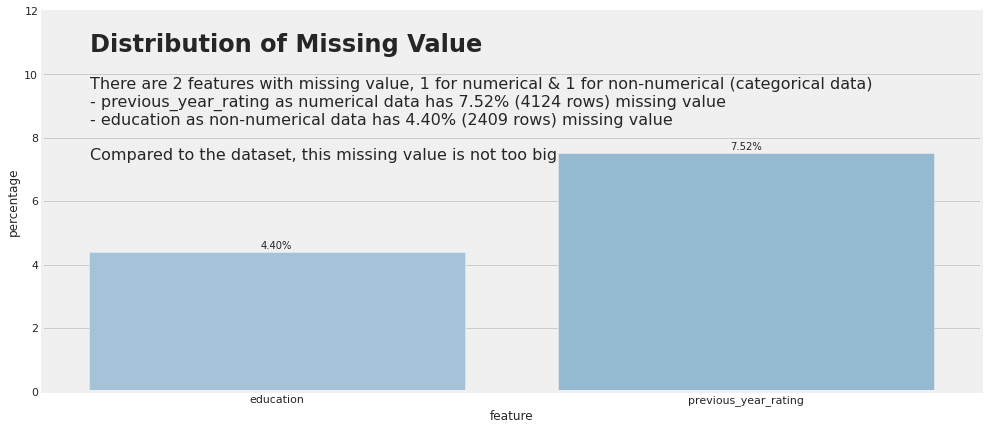

In [10]:
fig, ax = plt.subplots(figsize = (15,7))

mvalue_plot = sns.barplot(x='feature', y='percentage', data=data_missing,
           palette = sns.color_palette('Blues_d', n_colors = 13, desat = 1))

ax.set_ylim(0,12)

for p in mvalue_plot.patches:
    height = p.get_height()
    mvalue_plot.text(x = p.get_x() + (p.get_width()/2),
                y = height + 0.1,
                s = str('{:.2f}'.format(height)) + '%',
                ha = 'center')

title = '''Distribution of Missing Value'''
fig.text(x=0.125, y=0.8, s = title, fontsize = 24, weight = 'bold')

text = '''
There are 2 features with missing value, 1 for numerical & 1 for non-numerical (categorical data)
- previous_year_rating as numerical data has 7.52% (4124 rows) missing value
- education as non-numerical data has 4.40% (2409 rows) missing value

Compared to the dataset, this missing value is not too big
'''
fig.text(x=0.125, y=0.55, s = text, fontsize=16)

#plt.savefig('fig/Distribution of Missing Value.png')


**There are 2 features with missing value, 1 numeric & 1 non-numeric. the `education` feature with non-numeric data types has 4.40% missing value and the `previous_year_rating` feature with numeric data types has 7.52% missing value. When compared with the total row data, the number of missing values is relatively small.**

#### Check Cardinality or Unique Value from Categocial Data
<a id = 'unique_value' ></a>

In [11]:
# check the cardinality or unique value from categorical data 
# and assign thgem into data_cat_unique object
display(data.select_dtypes(include=['object']).columns)
print(data.select_dtypes(include=object).shape)
data_cat = data.select_dtypes(include=['object'])
data_cat.head(3)

Index(['department', 'region', 'education', 'gender', 'recruitment_channel'], dtype='object')

(54808, 5)


,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing


In [12]:
data_cat_unique = data_cat.nunique().reset_index()
data_cat_unique.columns = ['feature', 'unique value']
data_cat_unique = data_cat_unique.sort_values('unique value', ascending=False).reset_index(drop=True)
data_cat_unique

,feature,unique value
0,region,34
1,department,9
2,education,3
3,recruitment_channel,3
4,gender,2


<function matplotlib.pyplot.tight_layout>

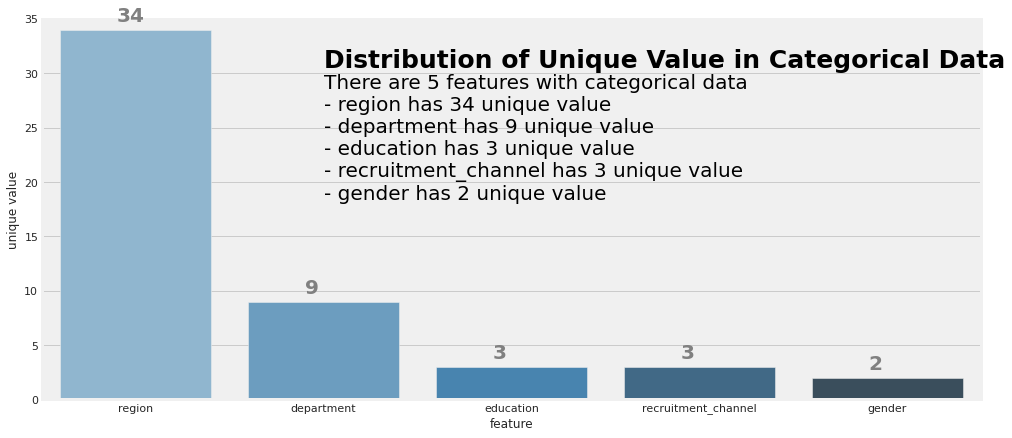

In [13]:
#Distribution of Unique Value in Categorical Data
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x = 'feature',y='unique value',data=data_cat_unique,ax=ax, 
               palette=sns.color_palette("Blues_d", n_colors=5, desat=1))

x = np.arange(len(data_cat_unique['feature']))
y = data_cat_unique['unique value']

for i, v in enumerate(y):
    ax.text(x[i]- 0.1, v+0.75, str(v), fontsize = 20, color='gray', fontweight='bold')
    
title = '''
Distribution of Unique Value in Categorical Data
'''
ax.text(1,28,title,horizontalalignment='left',color='black',fontsize=25,fontweight='bold')
    

text = '''
There are 5 features with categorical data
- region has 34 unique value
- department has 9 unique value
- education has 3 unique value
- recruitment_channel has 3 unique value
- gender has 2 unique value

'''
plt.text(1,23,text,horizontalalignment='left',color='black',fontsize=20,fontweight='normal',va='center')
    
ax.set_ylim(0,35)

ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
plt.tight_layout

#plt.savefig('fig/Insight Awal ke-9.png')

#### Check Dulicated Data

In [14]:
data.duplicated().sum()

0

**In the raw data, there are no duplicate values**

**Early Brief**<br>
* Dataset has 14 features and 54808 rows
* 5 features are in categorical data **(inlude 1 feature as target, `is_promoted`)**
* 9 features are in numerical data
* There are 2 features with missing value: 
    - 2409 rows in `education`
    - 4124 rows in `previous_year_rating`
* There are no duplicated data, at least before data preparation 

# Data Preparation

## Fix The Duplicate Values

In [15]:
data_clean = data.copy()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [16]:
data_clean.duplicated().sum()

0

**there are no duplicate from this dataset**

## Fix The Missing Value

**Remove `employee_id` since every rows have each unique values***</br>

From this step, the dataset is changed into new object called `data_clean`
* `data_clean` was created to save the clean data (fix missing value and duplicated data)
* The *feature engineering* results will be saved into `data_clean`

In [17]:
data_clean['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

__*Fix the missing value in `education` feature with `mode()` function to fill them with the most frequently occuring values*__

In [18]:
data_clean['education'] = data_clean['education'].fillna(data_clean['education'].mode()[0])

In [19]:
data_clean['education'].value_counts()

Bachelor's          39078
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

__*Fix the missing value in `previous_year_rating` feature with `median()` function to fill them with the median values. The reason is the distribution of this feature looks normal (the `mean` value and `median` value is close enough)*__

In [20]:
data_clean['previous_year_rating'].fillna(data_clean['previous_year_rating'].median(), inplace=True)

In [21]:
data_clean.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

## Feature Engineering

Based on the dataset, we decided to create 4 new features using the data from existing features

1. `potential_region`: contains the information of whether an employee was placed in potential region to be promoted or not
2. `performance_level`: contains the information that show the performance level of an employee. This feature comes from combination of `previous_year_rating`, `KPIs_met >80%`, and `awards_won?`
3. `High_Avg_Tscore`: contains the information of whether the average training score of an employee is high enough for promotion chance based on the previous data
4. `male`: contains the information to show an employee gender

### `potential_region`

*Contains the information of whether an employee was placed in potential region to be promoted or not*</br>
**1. based on the probability information on [promoted_by_region](#promoted_by_region), there are 8 regions that have a higher potential than other regions, namely with a probability value> 10%**</br>
**2. The regions are 4, 17, 25, 28, 23, 22, 3, 7 (in the order starting from the one with the highest probability value)**</br>
**3. if the employee is in the region, it will have a value of '1' otherwise it will be worth '0'**


In [22]:
data_cat = data_clean.select_dtypes(include=['object'])
data_cat_unique = data_cat.nunique().reset_index()
data_cat_unique.columns = ['feature', 'unique count']
data_cat_unique = data_cat_unique.sort_values('unique count', ascending=False)
data_cat_unique

,feature,unique count
1,region,34
0,department,9
2,education,3
4,recruitment_channel,3
3,gender,2


In [23]:
data_clean['potential_region'] = np.where(data_clean['region'].isin(['region_4','region_17','region_25','region_28','region_23',
                                                   'region_3','region_7']),
                              1, 0)
data_clean.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,potential_region
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,1
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,1
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,0


In [24]:

potential_reg_probs = data_clean.groupby(['potential_region', 'is_promoted']).agg({
    'department': ['count']
}).reset_index()

potential_reg_probs.columns = ['potential_region', 'is_promoted','employees']

potential_reg_probs = pd.pivot_table(potential_reg_probs,
                             index = 'potential_region',
                             columns = 'is_promoted',
                             values = 'employees').reset_index()

potential_reg_probs.columns = ['potential_region','not_promoted','promoted']
potential_reg_probs['total_employees'] = potential_reg_probs['not_promoted'] + potential_reg_probs['promoted']
potential_reg_probs['promotion_probs'] = (potential_reg_probs['promoted']/(potential_reg_probs['not_promoted']+potential_reg_probs['promoted']))*100
potential_reg_probs = potential_reg_probs.sort_values('promotion_probs', ascending=False).reset_index(drop=True)
potential_reg_probs['potential_region'] = np.where(potential_reg_probs['potential_region'] == 1, 'YES', 'NO')
potential_reg_probs

,potential_region,not_promoted,promoted,total_employees,promotion_probs
0,YES,9698,1302,11000,11.836364
1,NO,40442,3366,43808,7.683528


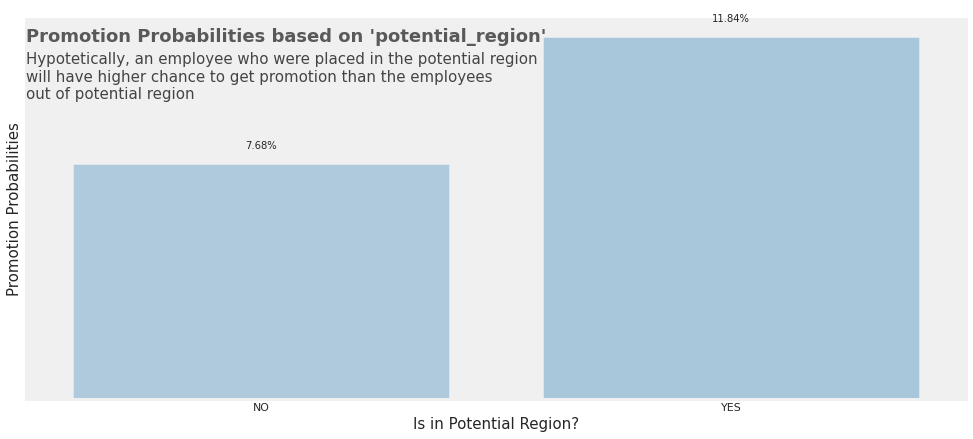

In [25]:
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x='potential_region', y='promotion_probs', data=potential_reg_probs,
                order=potential_reg_probs.sort_values('promotion_probs')['potential_region'],
                palette=sns.color_palette("Blues_d", n_colors=40, desat=1)
               )

for p in g.patches:
    height = p.get_height()
    plt.text(x = p.get_x() + (p.get_width()/2),
           y = height + 0.5,
           s = str('{:.2f}'.format(height)) + '%',
           ha = 'center'
          )

title = '''
Promotion Probabilities based on 'potential_region'
'''

text = '''
Hypotetically, an employee who were placed in the potential region
will have higher chance to get promotion than the employees 
out of potential region
'''

plt.yticks([]) # Hide the y-axis with empty list
plt.xlabel('Is in Potential Region?', fontsize = 15) # Add the x-label
plt.ylabel('Promotion Probabilities', fontsize = 15) # Add the y-label

plt.text(x = -0.5, y = 11, s=title,
        fontsize = 18, weight = 'bold', alpha = .75)
plt.text(x = -0.5, y = 9.25, s=text,
        fontsize = 15, alpha = .85);

#plt.savefig('fig/Insight Awal ke-3.png')

### `performance_level`

This feature comes from combination of `previous_year_rating`, `KPIs_met >80%`, and `awards_won?`

Based on the probability obtained in [promoted_by_kpi](#promoted_by_kpi), [previous_year_rating](#previous_year_rating), and [awards_won?](#awards_won?) have been shown that the probability will be higher if an employee met this 3 conditions

1. An employee who met their KPI > 80 % has higher chance to get promotion than others who didn't met their KPI
2. An employee who got 5 rating in the previous year has 9% higher chance to get promoted than others
3. An employee who won any award in the previous year has 36% higher chance to get promotion thanothers

This feature will have performance level as its value, from 1 `(low)` to 4 `(best)`, with the provisions below:
- if KPIs_met = 1 & rating = 5 & awards_won = 1, then `4 (Best)`
- if KPIs_met = 1 & rating = 4/5 & awards_won = 1/0, then `3 (Better)`
- if KPIs_met = 1 & rating = 3 & awards_won = 1/0, then `2 (Good)`
- else `1 (Low)`


In [26]:
# membuat fitur performance_level
data_clean['performance_level'] = np.where(
    (
        (data_clean['previous_year_rating'] == 5) &
        (data_clean['KPIs_met >80%'] == 1) &
        (data_clean['awards_won?'] == 1)
    ),
"Best",
    np.where((
        ((data_clean['previous_year_rating'] == 4) & (data_clean['KPIs_met >80%'] == 0) & (data_clean['awards_won?'] == 1)) | 
        ((data_clean['previous_year_rating'] == 4) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 0)) |
        ((data_clean['previous_year_rating'] == 4) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 1)) |
        ((data_clean['previous_year_rating'] == 5) & (data_clean['KPIs_met >80%'] == 0) & (data_clean['awards_won?'] == 1)) |
        ((data_clean['previous_year_rating'] == 5) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 0))
    ),
    "Better",
    np.where(
        ((data_clean['previous_year_rating'] == 3) & (data_clean['KPIs_met >80%'] == 0) & (data_clean['awards_won?'] == 1)) | 
        ((data_clean['previous_year_rating'] == 3) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 0)) |
        ((data_clean['previous_year_rating'] == 3) & (data_clean['KPIs_met >80%'] == 1) & (data_clean['awards_won?'] == 1)),
        "Good","Low"
    )
    )
)

In [27]:

perform_probs = data_clean.groupby(['performance_level', 'is_promoted']).agg({
    'department': ['count']
}).reset_index()

perform_probs.columns = ['performance_level', 'is_promoted','employees']

perform_probs = pd.pivot_table(perform_probs,
                             index = 'performance_level',
                             columns = 'is_promoted',
                             values = 'employees').reset_index()

perform_probs.columns = ['performance_level','not_promoted','promoted']
perform_probs['total_employees'] = perform_probs['not_promoted'] + perform_probs['promoted']
perform_probs['promotion_probs'] = (perform_probs['promoted']/(perform_probs['not_promoted']+perform_probs['promoted']))*100
perform_probs = perform_probs.sort_values('promotion_probs', ascending=False).reset_index(drop=True)
perform_probs

,performance_level,not_promoted,promoted,total_employees,promotion_probs
0,Best,114,125,239,52.301255
1,Good,5203,1232,6435,19.145299
2,Better,9460,1953,11413,17.112065
3,Low,35363,1358,36721,3.698156


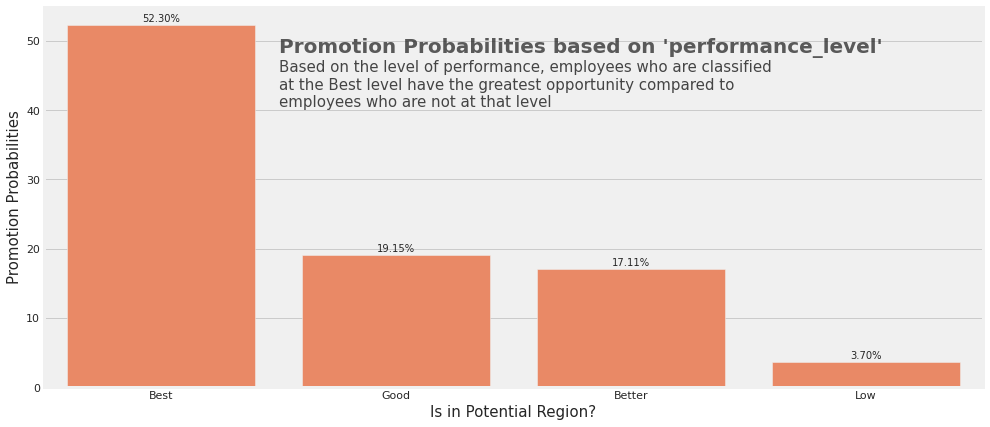

In [28]:
#Promotion Probabilities based on 'performance_level
fig, ax = plt.subplots(figsize=(15,7))

g = sns.barplot(x='performance_level', y='promotion_probs', data=perform_probs,
                order=perform_probs.sort_values('promotion_probs',ascending = False).performance_level,
                color='coral'
               )

for p in g.patches:
    height = p.get_height()
    plt.text(x = p.get_x() + (p.get_width()/2),
           y = height + 0.5,
           s = str('{:.2f}'.format(height)) + '%',
           ha = 'center'
          )

title = '''
Promotion Probabilities based on 'performance_level'
'''

text = '''
Based on the level of performance, employees who are classified
at the Best level have the greatest opportunity compared to 
employees who are not at that level
'''

#plt.yticks([]) # Hide the y-axis with empty list
plt.xlabel('Is in Potential Region?', fontsize = 15) # Add the x-label
plt.ylabel('Promotion Probabilities', fontsize = 15) # Add the y-label

plt.text(x = 0.5, y = 45, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)
plt.text(x = 0.5, y = 38, s=text,
        fontsize = 15, alpha = .85);

#plt.savefig('fig/Promotion by Performance Level.png')

### `High_Avg_Tscore`

This feature will have information on whether an employee has an average training score of more than or equal to 90 which has a greater chance of getting a promotion
1. based on the probability information on [avg_training_score](#avg_training_score), the opportunity for employees with a value greater than 90 is 76.83%
2. If the employee has this value then the value is '1' otherwise it will be worth '0'

In [29]:
data_clean['High_Avg_Tscore'] = np.where(data_clean['avg_training_score']>=90, 1, 0)
data_clean.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,potential_region,performance_level,High_Avg_Tscore
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,1,Better,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,0,Low,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,0,Low,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,1,Low,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,0,Low,0


### `male`

*Contains the information to show an employee gender from `gender` feature*
1. If the `gender` value is `m`, `male` feature will have value `1`, if not the value will be set to `0`
2. This is to reduce the feature encoding results that may be affect the number of feature


In [30]:
data_clean['male'] = np.where(data_clean['gender']=='m', 1, 0)
data_clean.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,potential_region,performance_level,High_Avg_Tscore,male
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,1,Better,0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,0,Low,0,1
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,0,Low,0,1
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,1,Low,0,1
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,0,Low,0,1


## Feature encoding
*To convert the categorical data into numerical format. The goal is to get the optimum learning process of our model. The technique we choose is `one-hot-encoding`. The reason is the cardinality of the categorical data is not too large*

### `department`

In [31]:
dummies_dept = pd.get_dummies(data_clean['department'], prefix='Dept')
data_clean = pd.concat([data_clean, dummies_dept], axis=1)

### `education`

In [32]:
dummies_edu = pd.get_dummies(data_clean['education'])
data_clean = pd.concat([data_clean, dummies_edu], axis=1)

### `recruitment_channel`

In [33]:
dummies_rc = pd.get_dummies(data_clean['recruitment_channel'])
data_clean = pd.concat([data_clean, dummies_rc], axis=1)

### `performance_level`

In [34]:
#merubah fitur performance_level dari data categorical menjadi numerik menggunakan metode one hot encoding
dummies_pl = pd.get_dummies(data_clean['performance_level'])
data_clean = pd.concat([data_clean, dummies_pl], axis=1)

In [35]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   employee_id             54808 non-null  int64  
 1   department              54808 non-null  object 
 2   region                  54808 non-null  object 
 3   education               54808 non-null  object 
 4   gender                  54808 non-null  object 
 5   recruitment_channel     54808 non-null  object 
 6   no_of_trainings         54808 non-null  int64  
 7   age                     54808 non-null  int64  
 8   previous_year_rating    54808 non-null  float64
 9   length_of_service       54808 non-null  int64  
 10  KPIs_met >80%           54808 non-null  int64  
 11  awards_won?             54808 non-null  int64  
 12  avg_training_score      54808 non-null  int64  
 13  is_promoted             54808 non-null  int64  
 14  potential_region        54808 non-null

## Logaritmik

__*From this step, we use `df_pre` as the dataset. At the beginning, this dataset was copied from `data_clean`. So this `df_pre` will be used to save the log transformation result, norm/std results*__


In [36]:
features = ['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?',
            'avg_training_score','is_promoted','potential_region','Dept_Analytics','Dept_Finance','Dept_HR','Dept_Legal',
            'Dept_Operations','Dept_Procurement','Dept_R&D','Dept_Sales & Marketing','Dept_Technology',"Bachelor's",
            'Below Secondary',"Master's & above", 'other','referred','sourcing','male','High_Avg_Tscore','Best','Better','Good','Low']

df_pre = data_clean.copy()
for var in features:
    df_pre['log_'+var]= (data_clean[var]+1).apply(np.log)

In [37]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 67 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   employee_id                 54808 non-null  int64  
 1   department                  54808 non-null  object 
 2   region                      54808 non-null  object 
 3   education                   54808 non-null  object 
 4   gender                      54808 non-null  object 
 5   recruitment_channel         54808 non-null  object 
 6   no_of_trainings             54808 non-null  int64  
 7   age                         54808 non-null  int64  
 8   previous_year_rating        54808 non-null  float64
 9   length_of_service           54808 non-null  int64  
 10  KPIs_met >80%               54808 non-null  int64  
 11  awards_won?                 54808 non-null  int64  
 12  avg_training_score          54808 non-null  int64  
 13  is_promoted                 548

In [38]:
df_pre.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,potential_region,High_Avg_Tscore,male,Dept_Analytics,Dept_Finance,Dept_HR,Dept_Legal,Dept_Operations,Dept_Procurement,Dept_R&D,Dept_Sales & Marketing,Dept_Technology,Bachelor's,Below Secondary,Master's & above,other,referred,sourcing,Best,Better,Good,Low,log_no_of_trainings,log_age,log_previous_year_rating,log_length_of_service,log_KPIs_met >80%,log_awards_won?,log_avg_training_score,log_is_promoted,log_potential_region,log_Dept_Analytics,log_Dept_Finance,log_Dept_HR,log_Dept_Legal,log_Dept_Operations,log_Dept_Procurement,log_Dept_R&D,log_Dept_Sales & Marketing,log_Dept_Technology,log_Bachelor's,log_Below Secondary,log_Master's & above,log_other,log_referred,log_sourcing,log_male,log_High_Avg_Tscore,log_Best,log_Better,log_Good,log_Low
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170,0.200701,0.013940,0.702379,0.097650,0.046271,0.044118,0.018957,0.207050,0.130236,0.018227,0.307254,0.130236,0.712998,0.014688,0.272314,0.555503,0.020836,0.423661,0.004361,0.208236,0.117410,0.669993,0.786834,3.556936,1.412488,1.758301,0.243970,0.016061,4.143877,0.059035,0.139115,0.067688,0.032074,0.030579,0.013145,0.143555,0.090271,0.012634,0.213013,0.090271,0.494141,0.010178,0.188721,0.384766,0.014450,0.293945,0.486852,0.009662,0.003025,0.144409,0.081360,0.464355
std,22586.581449,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137,0.400528,0.117241,0.457216,0.296844,0.210072,0.205358,0.136375,0.405195,0.336566,0.133774,0.461360,0.336566,0.452367,0.120300,0.445155,0.496914,0.142838,0.494142,0.065892,0.406050,0.321911,0.470219,0.207669,0.202229,0.323170,0.579772,0.331040,0.104284,0.203970,0.193483,0.277625,0.205811,0.145630,0.142334,0.094543,0.281006,0.233276,0.092712,0.320068,0.233276,0.313477,0.083435,0.308838,0.344727,0.098999,0.342529,0.316918,0.081265,0.045715,0.281494,0.223145,0.325928
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,3.044522,0.693147,0.693147,0.000000,0.000000,3.688879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,3.401197,1.386294,1.386294,0.000000,0.000000,3.951244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000,0.0

## Normalization

In [39]:
for var in features:
    df_pre['nor_'+var] = MinMaxScaler().fit_transform(df_pre[var].values.reshape(len(df_pre),1))

In [40]:
df_pre

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,potential_region,performance_level,High_Avg_Tscore,male,Dept_Analytics,Dept_Finance,Dept_HR,Dept_Legal,Dept_Operations,Dept_Procurement,Dept_R&D,Dept_Sales & Marketing,Dept_Technology,Bachelor's,Below Secondary,Master's & above,other,referred,sourcing,Best,Better,Good,Low,log_no_of_trainings,log_age,log_previous_year_rating,...,log_Master's & above,log_other,log_referred,log_sourcing,log_male,log_High_Avg_Tscore,log_Best,log_Better,log_Good,log_Low,nor_no_of_trainings,nor_age,nor_previous_year_rating,nor_length_of_service,nor_KPIs_met >80%,nor_awards_won?,nor_avg_training_score,nor_is_promoted,nor_potential_region,nor_Dept_Analytics,nor_Dept_Finance,nor_Dept_HR,nor_Dept_Legal,nor_Dept_Operations,nor_Dept_Procurement,nor_Dept_R&D,nor_Dept_Sales & Marketing,nor_Dept_Technology,nor_Bachelor's,nor_Below Secondary,nor_Master's & above,nor_other,nor_referred,nor_sourcing,nor_male,nor_High_Avg_Tscore,nor_Best,nor_Better,nor_Good,nor_Low
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,1,Better,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0.693147,3.583519,1.791759,...,0.693359,0.000000,0.0,0.693359,0.000000,0.0,0.0,0.693359,0.0,0.000000,0.000000,0.375,1.00,0.194444,1.0,0.0,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,0,Low,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0.693147,3.433987,1.791759,...,0.000000,0.693359,0.0,0.000000,0.693147,0.0,0.0,0.000000,0.0,0.693359,0.000000,0.250,1.00,0.083333,0.0,0.0,0.350000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,0,Low,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0.693147,3.555348,1.386294,...,0.000000,0.000000,0.0,0.693359,0.693147,0.0,0.0,0.000000,0.0,0.693359,0.000000,0.350,0.50,0.166667,0.0,0.0,0.183333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,1,Low,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1.098612,3.688879,0.693147,...,0.000000,0.693359,0.0,0.000000,0.693147,0.0,0.0,0.000000,0.0,0.693359,0.111111,0.475,0.00,0.250000,0.0,0.0,0.183333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,0,Low,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0.693147,3.828641,1.386294,...,0.000000,0.693359,0.0,0.000000,0.693147,0.0,0.0,0.000000,0.0,0.693359,0.000000,0.625,0.50,0.027778,0.0,0.0,0.566667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0,0,Low,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0.693147,3.891820,1.386294,...,0.000000,0.000000,0.0,0.693359,0.693147,0.0,0.0,0.000000,0.0,0.693359,0.000000,0.700,0.50,0.444444,0.0,0.0,0.650000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0,0,Low,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0.693147,3.637586,1.098612,...,0.693359,0.693359,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.693359,0.000000,0.425,0.25,0.138889,0.0,0.0,0.283333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54805,13

# Machine Learning Modelling and Evaluation

## Split Train & Test

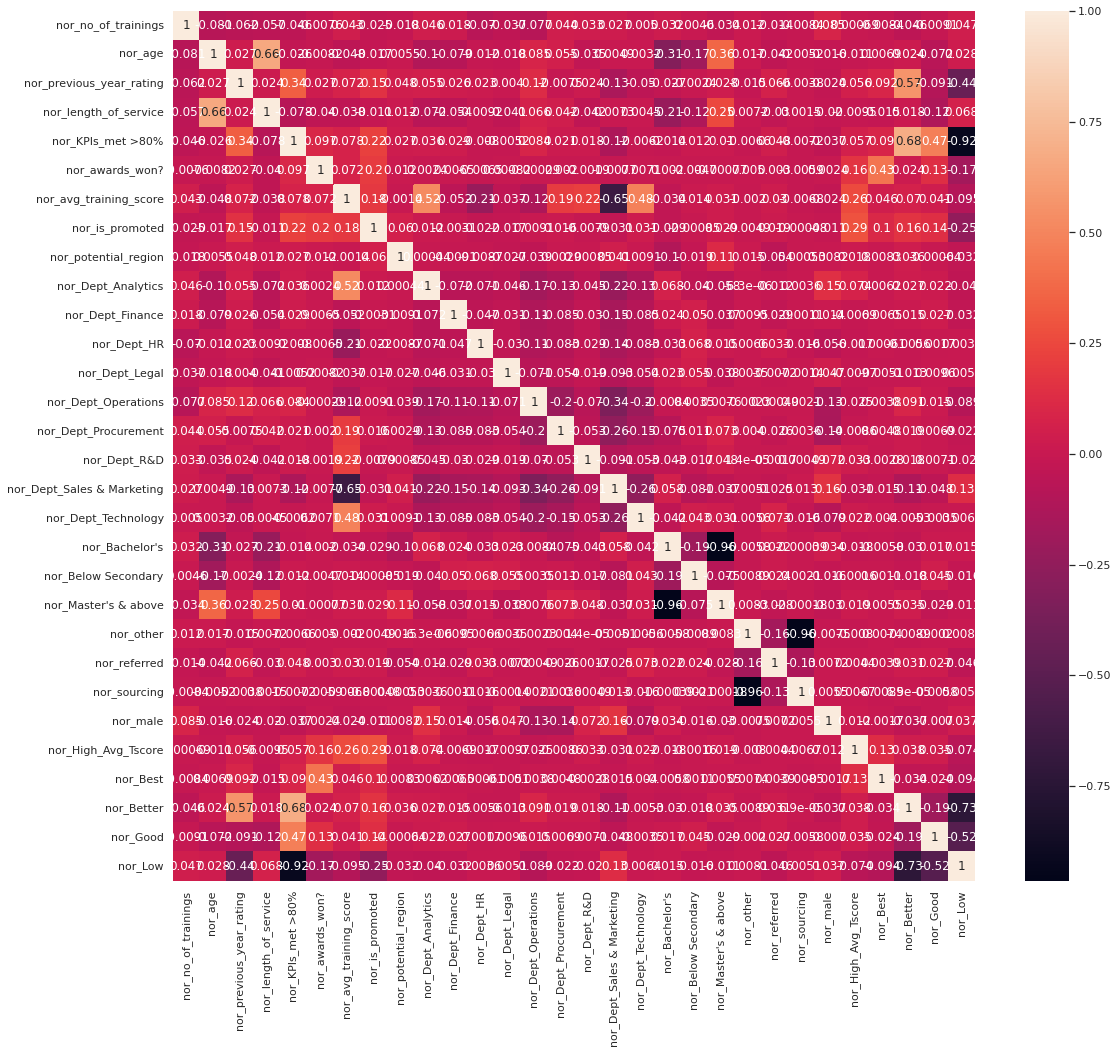

In [41]:
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(df_pre[['nor_no_of_trainings','nor_age','nor_previous_year_rating',
                    'nor_length_of_service','nor_KPIs_met >80%','nor_awards_won?',
                    'nor_avg_training_score','nor_is_promoted','nor_potential_region',
                    'nor_Dept_Analytics','nor_Dept_Finance','nor_Dept_HR','nor_Dept_Legal',
                    'nor_Dept_Operations','nor_Dept_Procurement','nor_Dept_R&D',
                    'nor_Dept_Sales & Marketing','nor_Dept_Technology',"nor_Bachelor's",
                    'nor_Below Secondary',"nor_Master's & above", 'nor_other','nor_referred',
                    'nor_sourcing','nor_male','nor_High_Avg_Tscore','nor_Best','nor_Better',
                    'nor_Good','nor_Low']].corr(), annot=True)
#plt.savefig('fig/split train test.png')

In [42]:
x_norm = df_pre[['nor_no_of_trainings','nor_age','nor_previous_year_rating',
            'nor_length_of_service','nor_KPIs_met >80%','nor_awards_won?',
            'nor_avg_training_score','nor_potential_region',
            'nor_Dept_Analytics','nor_Dept_Finance','nor_Dept_HR','nor_Dept_Legal',
            'nor_Dept_Operations','nor_Dept_Procurement','nor_Dept_R&D',
            'nor_Dept_Sales & Marketing','nor_Dept_Technology',"nor_Bachelor's",
            'nor_Below Secondary',"nor_Master's & above", 'nor_other','nor_referred',
            'nor_sourcing','nor_male','nor_High_Avg_Tscore',"nor_Best",'nor_Better','nor_Good','nor_Low']]
y_norm = df_pre['nor_is_promoted']

In [43]:
#Splitting the data into Train and Test
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_norm,
                                                y_norm,
                                                test_size=0.2, random_state=42) 

In [44]:
df_pre.shape

(54808, 97)

In [45]:
xtrain.shape

(43846, 29)

In [46]:
xtest.shape

(10962, 29)

## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42, solver = 'liblinear')
logreg_model = logreg.fit(xtrain, ytrain)

In [48]:
# Predict the test data
y_predicted = logreg.predict(xtest)
y_predicted

array([0., 0., 0., ..., 0., 0., 0.])

In [49]:
'''
The output of a Logistic regression model is a probability. 
We can select a threshold value. 
If the probability is greater than this threshold value, 
the event is predicted to happen otherwise it is predicted not to happen.

To get the probability of the label, repectively for class 0 and 1
'''

y_predicted_proba = logreg.predict_proba(xtest)
y_predicted_proba

array([[0.9865461 , 0.0134539 ],
       [0.99095139, 0.00904861],
       [0.96644298, 0.03355702],
       ...,
       [0.81144079, 0.18855921],
       [0.98833637, 0.01166363],
       [0.97319165, 0.02680835]])

In [50]:
print('\nclassification report')
print(classification_report(ytest, y_predicted)) # generate the precision, recall, f-1 score, num
print('LogReg: ROC AUC = ',str(round(roc_auc_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Precision = ',str(round(precision_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Recall = ',str(round(recall_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: Accuracy = ',str(round(accuracy_score(ytest, y_predicted)*100,1)), '%')
print('LogReg: F1-Score = ',str(round(f1_score(ytest, y_predicted)*100,1)), '%')
confusion_matrix(ytest, y_predicted)


classification report
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     10054
         1.0       0.86      0.24      0.38       908

    accuracy                           0.93     10962
   macro avg       0.90      0.62      0.67     10962
weighted avg       0.93      0.93      0.92     10962

LogReg: ROC AUC =  61.9 %
LogReg: Precision =  85.5 %
LogReg: Recall =  24.1 %
LogReg: Accuracy =  93.4 %
LogReg: F1-Score =  37.6 %


array([[10017,    37],
       [  689,   219]])

In [51]:
#Save Machine Learning Model
import pickle
pickle.dump(logreg_model, open('Logreg.pkl', 'wb'))

In [52]:
#Load and print model score
loaded_model = pickle.load(open('Logreg.pkl', 'rb'))
result = loaded_model.score(xtest,ytest)
print(result)

0.9337712096332786


In [53]:
#print model score to check if the model is overfitting or not
print('train score : ', str(round(loaded_model.score(xtrain, ytrain)*100,2)), '%')
print('test score : ', str(round(loaded_model.score(xtest, ytest)*100,2)),'%')

train score :  93.14 %
test score :  93.38 %


# Summary
The percentage of employees who get promoted is 8.68 %
The number of employees who get promoted using the model are 2040 out of 23490 employees